<a href="https://colab.research.google.com/github/nafisa-maliyat/cvpr2/blob/main/mid/MID_CP_kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import statistics
import random
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
DATA_DIR = '/content/drive/MyDrive/cvpr/test'
IMG_SIZE = 32
CATEGORIES = [i for i in os.listdir(DATA_DIR)]

print(CATEGORIES)

['ship', 'deer', 'horse', 'automobile', 'cat', 'airplane', 'truck', 'frog', 'bird', 'dog']


In [3]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
            training_data.append([img_gray, class_num])
        except:
            pass

print(len(training_data))

100%|██████████| 1000/1000 [00:22<00:00, 44.98it/s]

10000


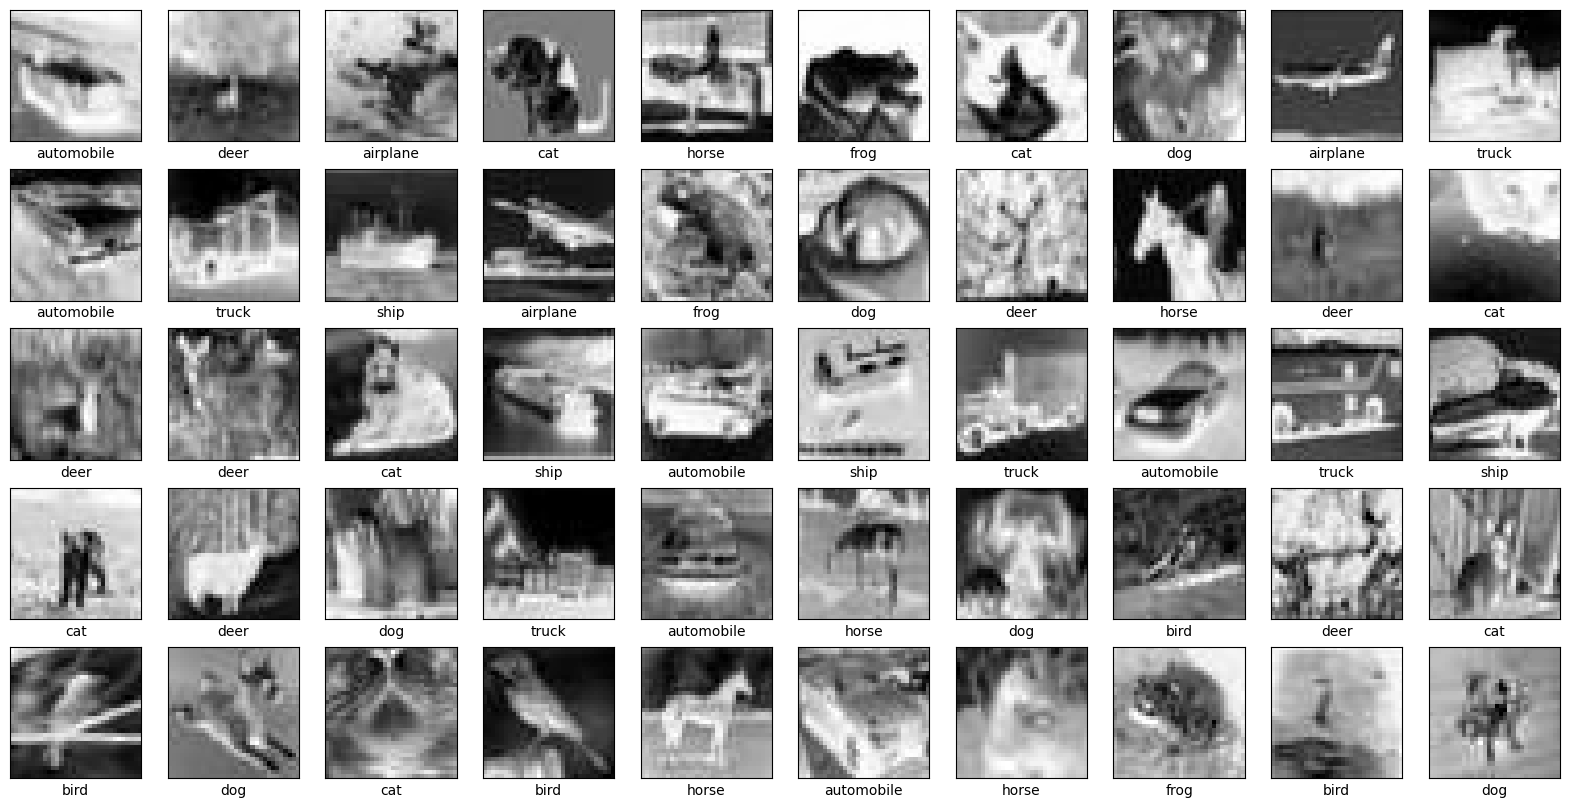

In [4]:
random.shuffle(training_data)
plt.figure(figsize=(20,10))

for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(training_data[i][0], cmap='gray_r')
    plt.xlabel(CATEGORIES[training_data[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==50:
        break
plt.show()

In [5]:
f1 = training_data[0:2000]
f2 = training_data[2000:4000]
f3 = training_data[4000:6000]
f4 = training_data[6000:8000]
f5 = training_data[8000:10000]
folds = [f1, f2, f3, f4, f5]

In [6]:
def manhattan_distance(img1, img2):
    return np.sum(np.abs(img1 - img2))


def euclidian_distance(img1, img2):
    return np.sqrt(np.sum((img1 - img2) ** 2))


def normalize(data):
    return [[np.round(img_array / 255, 3), class_num] for [img_array, class_num] in data]


def by_l1_dist(list):
    return list[2]["l1"]


def by_l2_dist(list):
    return list[2]["l2"]

In [7]:
top_filter = 20


def cal_dist(train_fold, valid_fold):
    l1_result = []
    l2_result = []
    for valid in tqdm(valid_fold):  # valid = [img_resized, class_num]
        temp_dist_list = []
        for train in train_fold:    # train = [img_resized, class_num]
            l1_dist = manhattan_distance(valid[0], train[0])
            l2_dist = euclidian_distance(valid[0], train[0])
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_dist, "l2": l2_dist}])
        # sort by L1
        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        # sort by L2
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])
    return [l1_result, l2_result]


In [8]:
k_range = 20
def cal_accuracy(dist_result, dist_term):
    k_accuracies = []  # k_range values
    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)
            if k % 2 != 0:                      # k is ODD
                if ((k-1) / 2) < same_class_len:  # majority has same class
                    img_accuracy += 1
            else:                                   # k is EVEN
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):    # majority has same class
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist < diff_class_dist:   # same class has lesser distance
                        img_accuracy += 1
        k_accuracies.append(img_accuracy/len(dist_result))
    return k_accuracies

In [9]:
# PRE PROCESS
normal_folds = [normalize(data) for data in folds]

In [10]:
dist_by_fold = []

for fold_num in range(len(folds)):
  valid_fold = normal_folds[fold_num]
  train_fold = sum([fold for j, fold in enumerate(normal_folds) if fold_num != j], [])
  dist_by_fold.append(cal_dist(train_fold, valid_fold))  #[ l1_result, l2_result ] = cal_dist(train_fold, valid_fold)

100%|██████████| 2000/2000 [07:28<00:00,  4.46it/s]


In [13]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])

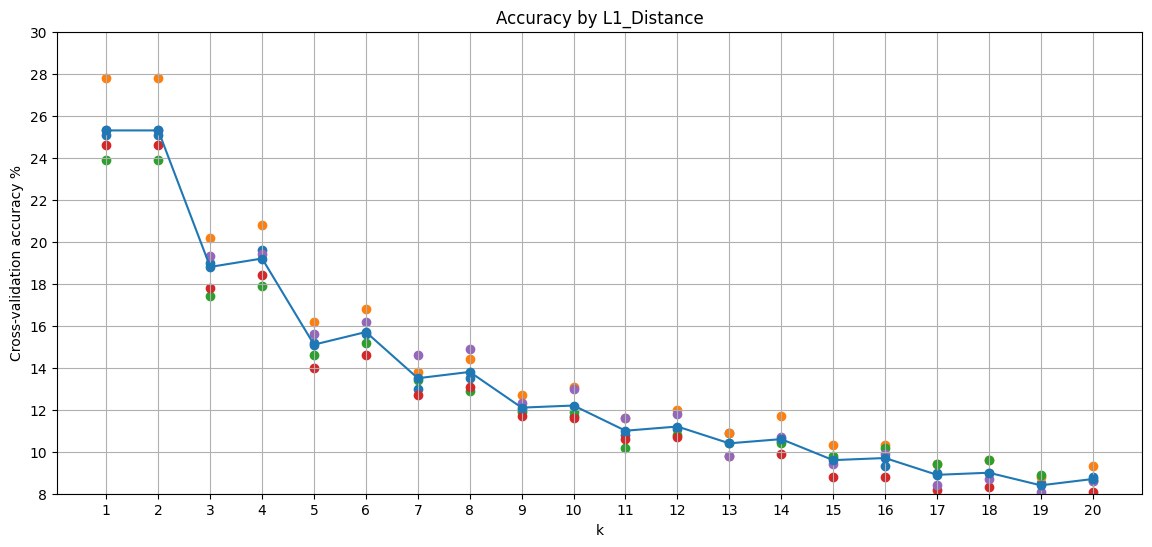

In [14]:
# Accuracy by L1_Distance
x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))

for fold in accuracies:
  y_list = [round(acc*100, 1) for acc in fold[0]] # fold[0] = l1_accurracy
  plt.scatter(x_list, y_list)
#calculate equation for quadratic trendline
arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])
trend = [round(np.mean(a)*100,1) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')

plt.title('Accuracy by L1_Distance')
plt.xticks(x_list)
plt.yticks(list(range(8, 31, 2)))
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy %')
plt.ylim([8, 30])

plt.show()

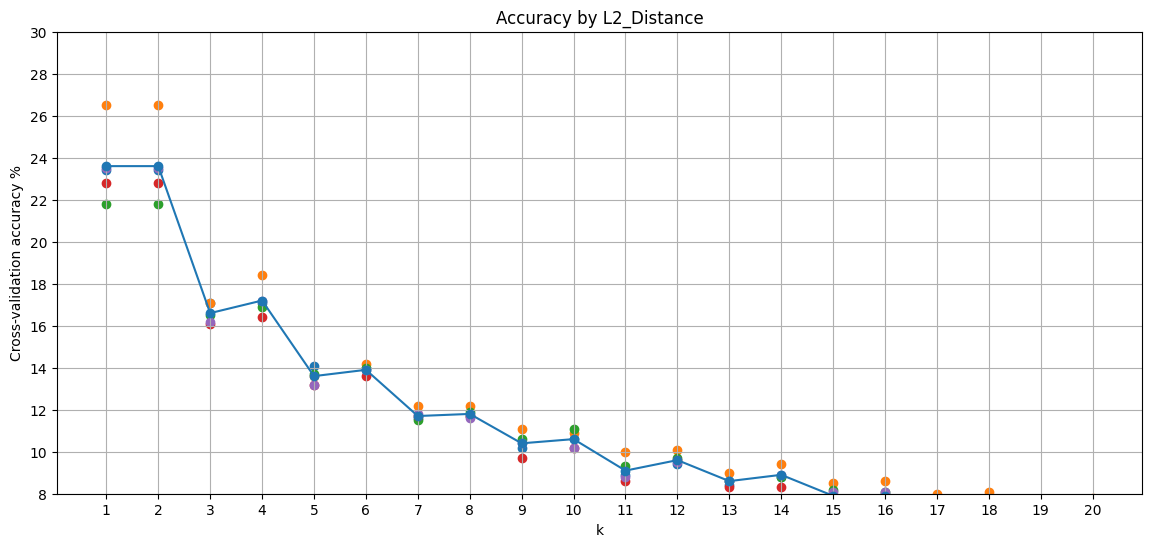

In [15]:
# Accuracy by L2_Distance
x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))

for fold in accuracies:
  y_list = [round(acc*100, 1) for acc in fold[1]] # fold[1] = l2_accurracy
  plt.scatter(x_list, y_list)
#calculate equation for quadratic trendline
arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])
trend = [round(np.mean(a)*100,1) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')

plt.title('Accuracy by L2_Distance')
plt.xticks(x_list)
plt.yticks(list(range(8, 31, 2)))
plt.grid(True)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy %')
plt.ylim([8, 30])

plt.show()

# Discussion
## Process

1. We shuffled the list of training images to ensure randomness in our dataset and then selected 10,000 images for further processing.

2. The selected 10,000 training images were divided into a 5-Fold cross-validation setup. This process helps ensure that the model is tested on various subsets of the data.

3. To prepare the data for distance calculations, we normalized the pixel values for each image, scaling them from the original range to a new range from 0 to 1. This normalization helps ensure that pixel values do not dominate the distance metrics.

4. For model evaluation, we calculated both Manhattan distance (L1 distance) and Euclidean distance (L2 distance) using a 5-Fold cross-validation approach. In each fold, one subset was used as the validation set, while the remaining subsets were used for training.

5. We calculated the accuracy for each distance metric (L1 and L2) separately. This provides insights into how well our model is performing based on these different distance metrics.

6. Finally, we visualized our results by plotting two scatter diagrams. These diagrams show the mean accuracy for different k-values, allowing us to understand how the choice of k (number of neighbors) impacts the performance of our model using both L1 and L2 distances.



## Analysis:
* In the cross-validation accuracy graph for L1 distance, we observe consistently superior accuracy across all k values.
* Specifically, when examining the L1 accuracy graph, we identify the peak mean accuracy occurring at k=1 and k=2.
* However, beyond k=2, the mean accuracy experiences a decline due to the potential for various classes to exhibit the closest proximity in the dataset.
* It's also important to note that, when employing an even k value, the likelihood of encountering ties increases, resulting in diminished accuracy.

Test Image 1 (True Label: 9)


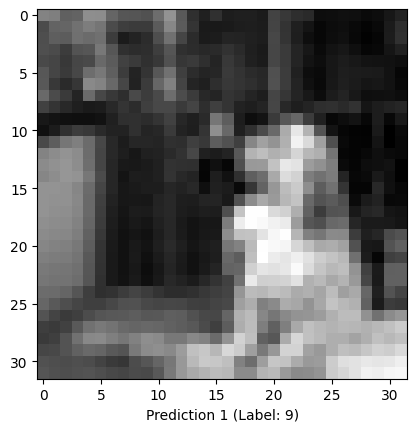

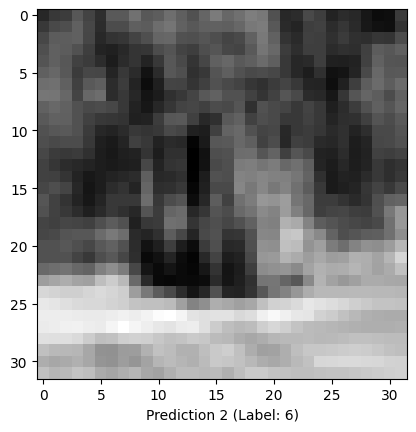

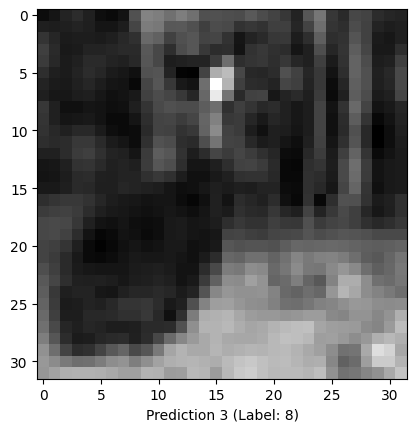

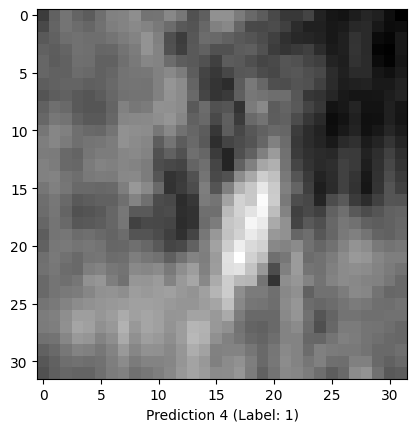

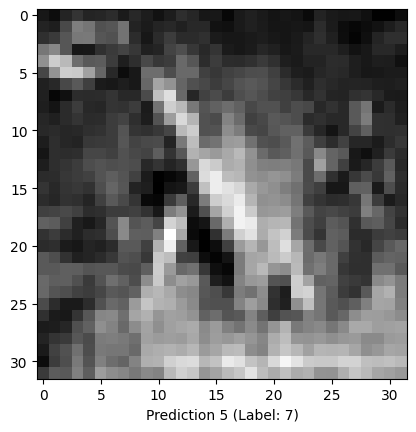

Test Image 2 (True Label: 6)


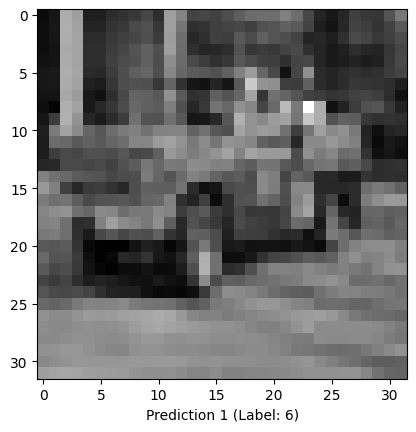

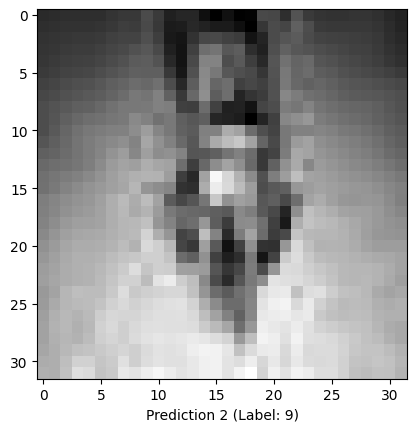

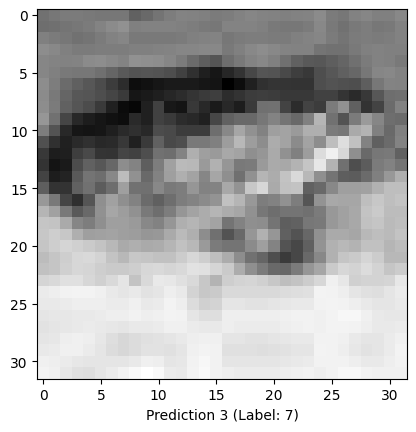

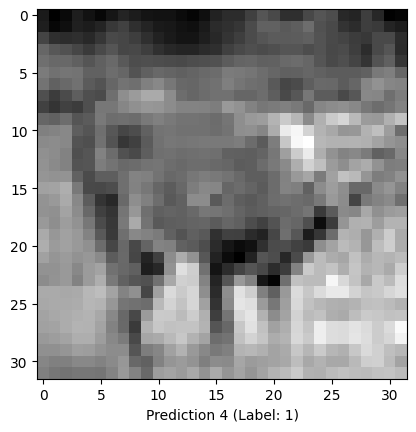

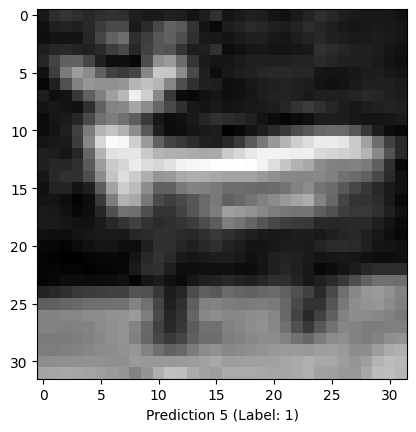

Test Image 3 (True Label: 9)


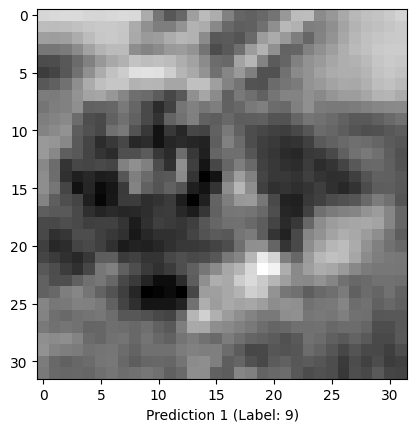

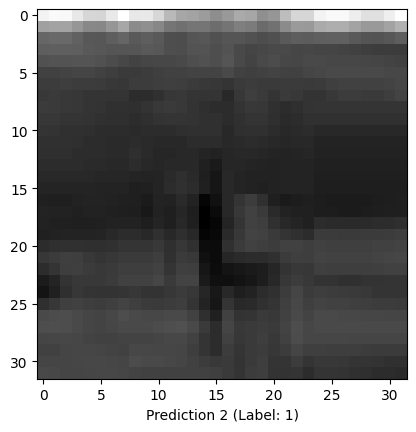

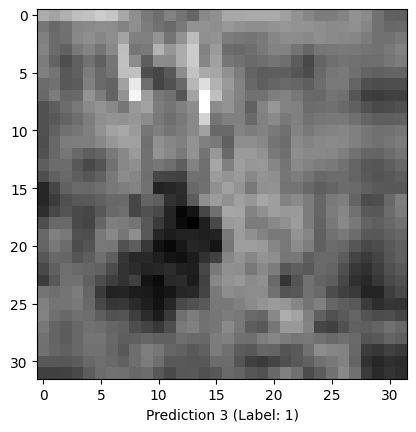

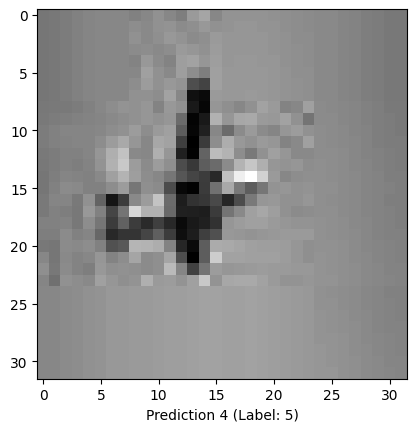

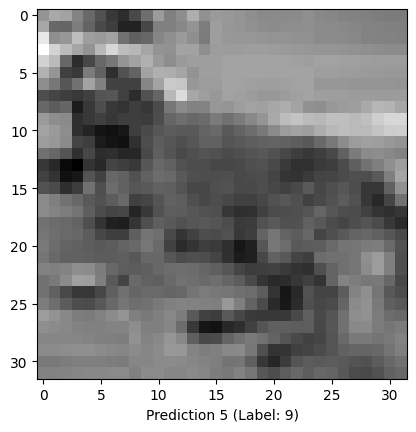

Test Image 4 (True Label: 2)


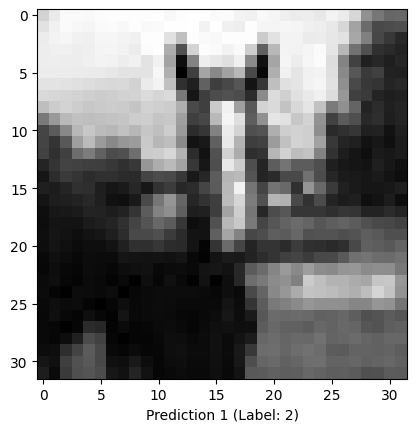

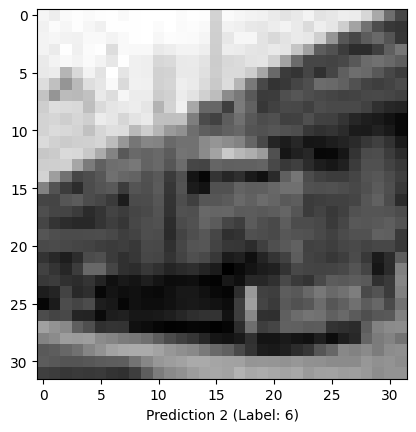

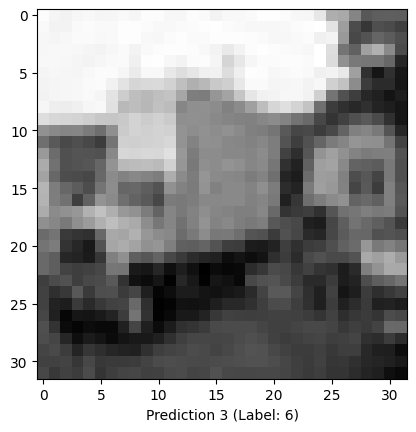

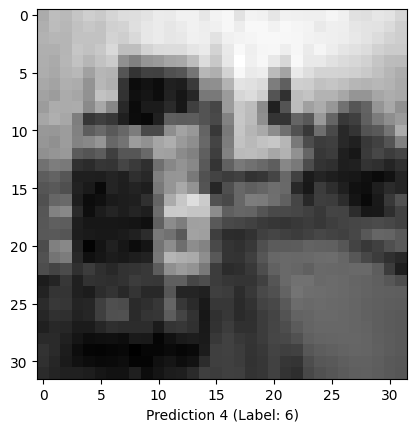

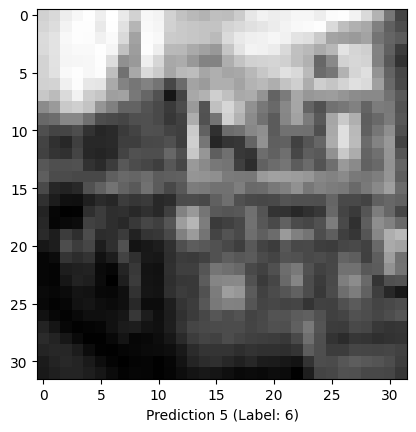

Test Image 5 (True Label: 0)


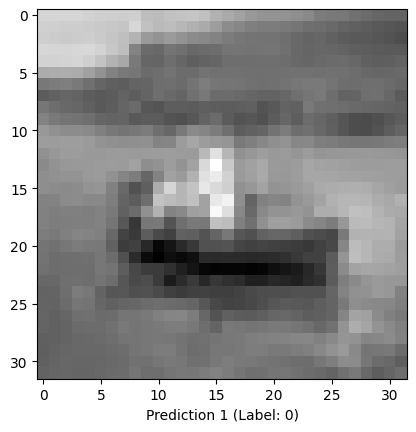

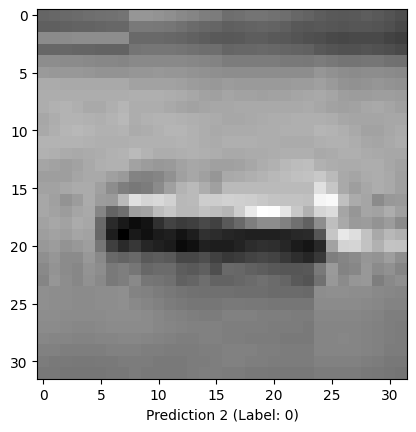

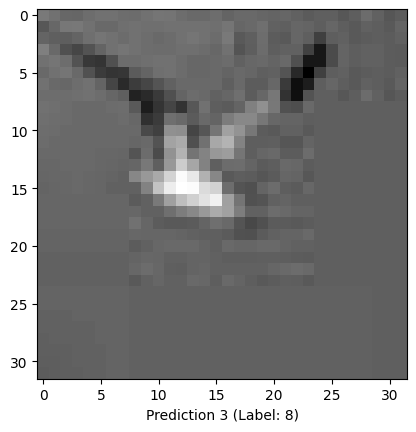

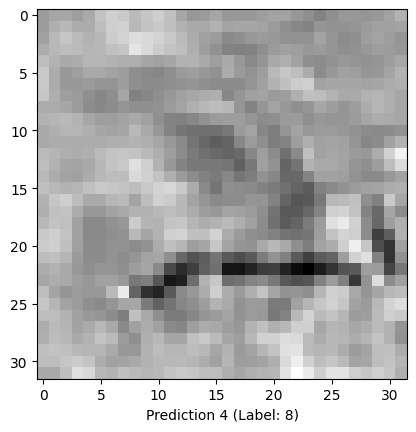

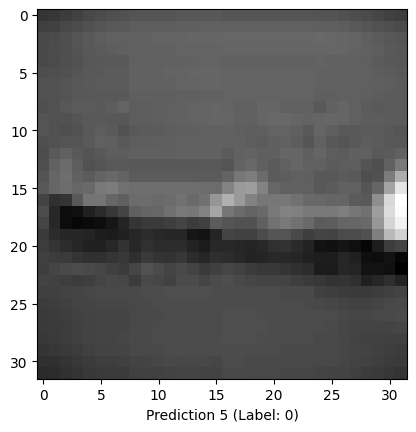

------------------------------


In [18]:
num_test_images = 5
X = [item[0] for item in training_data]  # Extract image data
y = [item[1] for item in training_data]  # Extract class labels

test_indices = random.sample(range(len(X)), num_test_images)
test_images = [X[i] for i in test_indices]
test_labels = [y[i] for i in test_indices]
# Flatten the grayscale images
X_flattened = [img.flatten() for img in X]

# Train a K-NN model
k = 11
distance_metric = 'manhattan'
knn_classifier = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)
knn_classifier.fit(X_flattened, y)

test_prediction = []

for test_image, test_label in zip(test_images, test_labels):
    # Flatten the test image
    test_image_flat = test_image.flatten()

    distances, indices = knn_classifier.kneighbors([test_image_flat], n_neighbors=num_test_images)
    images = [X[i] for i in indices[0]]
    labels = [y[i] for i in indices[0]]
    test_prediction.append((test_image, test_label, images, labels))

# Display the results
for i, (test_image, test_label, images, labels) in enumerate(test_prediction):
  print(f"Test Image {i + 1} (True Label: {test_label})")
  for j, (top_image, top_label) in enumerate(zip(images, labels)):
    plt.xlabel(f"Prediction {j + 1} (Label: {top_label})")
    plt.imshow(top_image.reshape((IMG_SIZE, IMG_SIZE)), cmap='gray')
    plt.show()
print("-" * 30)